In [1]:
# Jalankan kalau belum pernah install
!pip install scikit-image

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog

from skimage import measure
from skimage import morphology

In [11]:
def labeled_user_image(image,k = 0):

    imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (thresh, im_bw) = cv2.threshold(imgray, 90, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #im_bw= cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
    im_bw = np.array(255-im_bw, dtype=bool)
    cleaned = morphology.remove_small_objects(im_bw, min_size=20, connectivity=2)
    cleaned = np.array(cleaned, dtype=int)
    cleaned = 255+cleaned
    label, n = measure.label(cleaned, background=255, return_num=True, connectivity=2)
    print("numbers of numbers on image : ",n)
    x = []
    y = []
    numbers = []
    ph=[]
    rect=[]
    for i in range(1, n + 1):
        for r in range(label.shape[0]):
            for c in range(label.shape[1]):
                if label[r, c] == i:
                    x.append(c)
                    y.append(r)

        digit = im_bw[min(y): max(y), min(x): max(x)]

        rect.append([(min(x), min(y)), (max(x) - min(x)), (max(y) - min(y))])

        #tidak terpakai
        padd_y = 0
        padding = np.zeros([digit.shape[0]+padd_y, digit.shape[1] + k], dtype='float64')
        padding[padd_y//2:padding.shape[0]-padd_y//2, k//2:padding.shape[1] - k//2] = digit
        ph.append(padding)

        re_digit= cv2.resize(np.array(padding,dtype='float64'), (28, 28), interpolation=cv2.INTER_AREA)
        re_digit = cv2.dilate(re_digit, (3, 3))
        # Calculate the HOG features
        roi_hog_fd = hog(re_digit, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)

        numbers.append( np.array([roi_hog_fd], 'float64'))
        x = []
        y = []

    return numbers,ph,rect

numbers of numbers on image :  2
rect :  [[(23, 24), 68, 101], [(108, 33), 49, 90]]


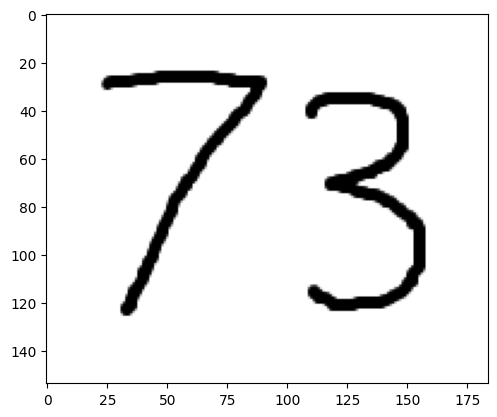

In [14]:
# Cara penggunaan
image_path = '73.png'
image = cv2.imread(image_path)
numbers, ph, rect = labeled_user_image(image)

print("rect : ",rect)

plt.imshow(image)
# rect berupa list titik koordinat objek dan lebar serta tinggi
# gunakan value dari rect untuk melakukan prediction

In [16]:
!pip install keras

In [19]:

from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

y_cat_test = to_categorical(y_test, 10)
y_cat_train = to_categorical(y_train, 10)

x_train = x_train/255
x_test = x_test/255

x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [34]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size=(4,4), input_shape=(28,28,1), activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(32, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 25, 25, 32)          │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │         147,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,362 (579.54 KB)

 Trainable params: 148,362 (579.54 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.fit(x_train, y_cat_train, epochs=3)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8878 - loss: 0.3694
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.9805 - loss: 0.0652
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 16ms/step - accuracy: 0.9867 - loss: 0.0444


In [36]:
def detect_number(rect, image):
  rois = []
  for (x,y),w,h in rect:
    roi = image[y:y+h, x:x+w]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi = cv2.bitwise_not(roi)

    pad = 80
    padding = np.zeros([roi.shape[0]+pad, roi.shape[1]+pad], dtype='float64')
    padding[pad//2:padding.shape[0]-pad//2, pad//2:padding.shape[1]-pad//2] = roi

    padding = cv2.resize(np.array(padding,dtype='float64'), (28, 28), interpolation=cv2.INTER_AREA)
    padding = cv2.dilate(padding, (3, 3))

    padding = padding/255
    padding = padding.reshape(28, 28, 1)
    rois.append(padding)
  return rois

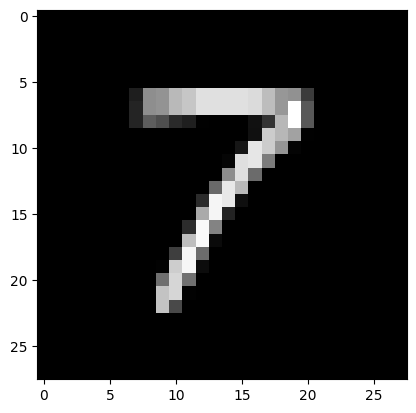

In [39]:
plt.imshow(x_ocr[0],cmap='gray')

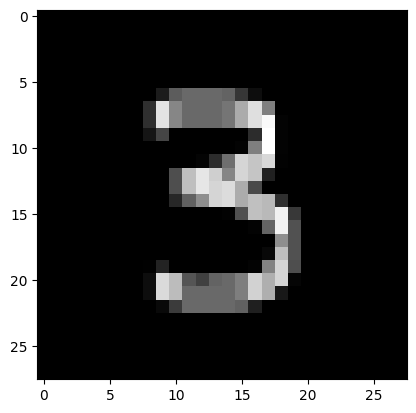

In [37]:
plt.imshow(x_ocr[1],cmap='gray')

In [38]:
x_ocr = detect_number(rect, image)
new_x = np.asarray(x_ocr)

predicted = model.predict(new_x)
classes = np.argmax(predicted, axis=1)
print(classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[7 3]


Prediksi sudah benar yaitu 7 dan 3